# Predicción de parámetros en estrellas masivas

* **Objetivo del proyecto**: Aprender a usar métodos ML para predecir parámetros estelares de espectros de estrellas masivas.

* **Descripción**: La estimación de parámetros estelares a partir de espectros es una tarea fundamental en astrofísica. En particular, el análisis de estrellas masivas requiere métodos precisos para estimar  parámetros como la temperatura efectiva (Teff), la velocidad de rotación (v sin i), la gravedad superficial (log g), la luminosidad estelar, la velocidad terminal del viento estelar, entre otros.

* **Datos**: ISOSCELES.  Se utilizará un subconjunto de la base de datos ISOSCELES, considerando específicamente la línea espectral H-alpha y fijando la velocidad de microturbulencia en 10 km/s. Además, se evaluará la capacidad del modelo para generalizar a espectros observados. Se predecirán los parámetros: **temperatura efectiva, log g, y pérdida de masa**.


## Bibliotecas de Python

In [30]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt

## Carga de espectros

In [142]:
# Dataset provided by PhD (c) Daniela Turis, IFA-UV.

# Verifica si estás en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # En Colab, usamos gdown
    import gdown
    !gdown https://drive.google.com/uc?id=14NHeV1fvE2HXMaghHAszf_92iTBVNJHL
    !gdown  https://drive.google.com/uc?id=1g56JSd46v1HjJkhpIw7Qkal--VDd7cpS
    !gdown  https://drive.google.com/uc?id=1YA9HYeOKHMYvt9M4LAaLkO8mpJjOXktV

    data = np.load("subset_vmic10.npy")
    y = np.load("y_subset_vmic10.npy")

else:
    # En entorno local, carga desde disco
    dir_path = "/Users/rpezoa/experiment_data/data_fo/data_vmic10/"
    if os.path.exists(dir_path):
        print("Archivo cargado localmente:", dir_path + "subset_vmic10.npy")
        data = np.load(dir_path + "subset_vmic10.npy")
        y = np.load(dir_path + "y_subset_vmic10.npy")
        data_observed = np.load("/Users/rpezoa/experiment_data/data_fo/data/X_observed.npy")
        data_observed_p = np.load("/Users/rpezoa/experiment_data/data_fo/data/X_observed_processed.npy")


    else:
        print("No se encontró el archivo local. Debes descargarlo manualmente.")

Archivo cargado localmente: /Users/rpezoa/experiment_data/data_fo/data_vmic10/subset_vmic10.npy


## Ejemplo de un espectro sintético

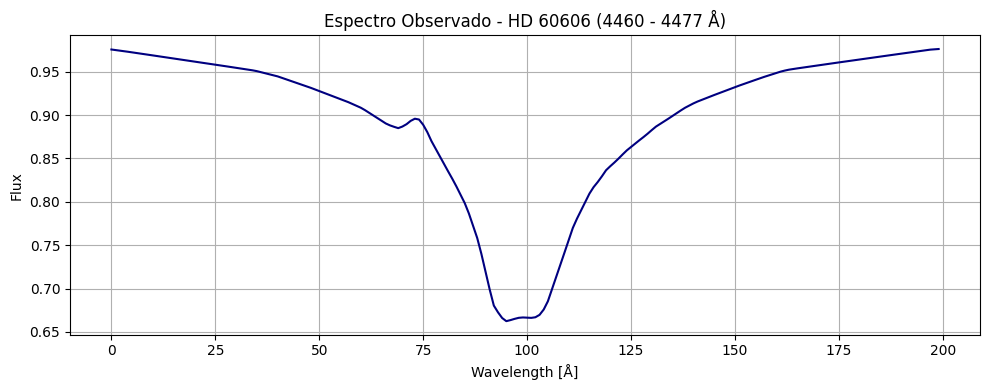

array([ 3.20000000e+04,  3.60000000e+00,  5.00389117e+00,  4.50000000e-01,
        2.50000000e-01,  3.30000000e-01,  4.16556090e+02, -7.04938602e+00,
        7.36000000e+00])

In [32]:
i = 1503
# Graficar el espectro
plt.figure(figsize=(10, 4))
plt.plot(range(200), data[i,:], color="navy", lw=1.5)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux")
plt.title("Espectro Observado - HD 60606 (4460 - 4477 Å)")
plt.grid(True)
plt.tight_layout()
# Guardar a archivo PNG
plt.savefig("spectrum_hd60606_4460_4477.png", dpi=300)
plt.show()

y[i]


## Etapas del proyecto
***

## Obtención de Datos


In [33]:
data.shape

(10000, 200)

In [35]:
y.shape
# TEFF (temperatura efectiva), LOGG (logaritmo de la gravedad superficial), LOGLSTAR (logaritmo de la luminosidad de la estrella), 
# # ALPHA, K, DELTA (alpha, k y delta son los parámetros de fuerza de línea), 
# # VINF (velocidad terminal), LOGMDOT (logaritmo de la tasa de pérdida de masa), SI (abundancia del silicio)



(10000, 9)

* Solo se debe seleccionar la TEFF, LOGG y 

## Exploratory Data Analysis (EDA)


In [63]:
y.shape
y_new = y[:, [0, 1, 7]]

/var/folders/wl/29l2l67d2cg4v094qj87xlkc0000gn/T/ipykernel_92384/4101013471.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend() # Mostrar etiquetas de cada curva


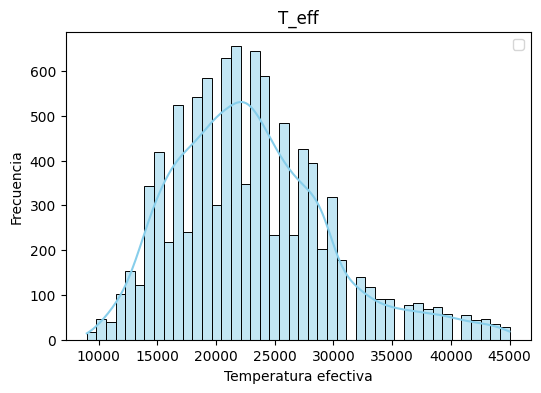

In [123]:
import seaborn as sns

plt.figure(figsize=(6, 4)) # Ajustar tamaño del gráfico
sns.histplot(y_new[:,0], kde=True, color="skyblue")
plt.legend() # Mostrar etiquetas de cada curva
plt.title("T_eff")
plt.xlabel("Temperatura efectiva")
plt.ylabel("Frecuencia")
plt.show()

/var/folders/wl/29l2l67d2cg4v094qj87xlkc0000gn/T/ipykernel_92384/3560532475.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend() # Mostrar etiquetas de cada curva


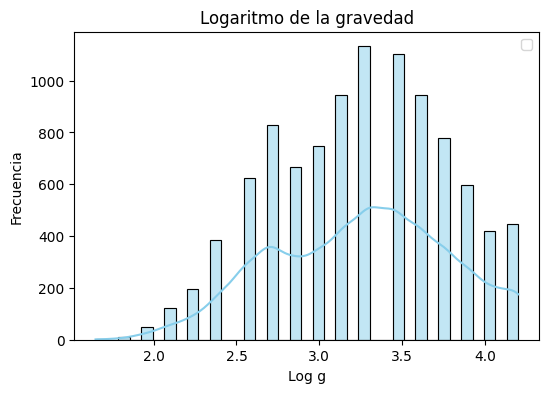

In [124]:
plt.figure(figsize=(6,4)) # Ajustar tamaño del gráfico
sns.histplot(y_new[:,1], kde=True, color="skyblue")
plt.legend() # Mostrar etiquetas de cada curva
plt.title("Logaritmo de la gravedad")
plt.xlabel("Log g")
plt.ylabel("Frecuencia")
plt.show()

/var/folders/wl/29l2l67d2cg4v094qj87xlkc0000gn/T/ipykernel_92384/1709018115.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend() # Mostrar etiquetas de cada curva


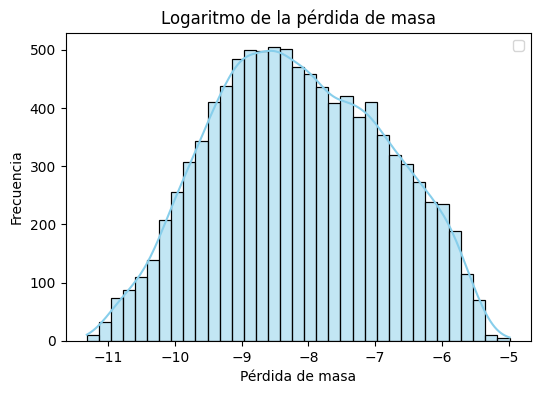

In [125]:
plt.figure(figsize=(6,4)) # Ajustar tamaño del gráfico
sns.histplot(y_new[:,2], kde=True, color="skyblue")
plt.legend() # Mostrar etiquetas de cada curva
plt.title("Logaritmo de la pérdida de masa")
plt.xlabel("Pérdida de masa")
plt.ylabel("Frecuencia")
plt.show()

## Generación de datos de training, validation, y testing


### Escalamiento de los datos

* Se escala los valores del output

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(y_new)
y_scaled = scaler.transform(y_new)


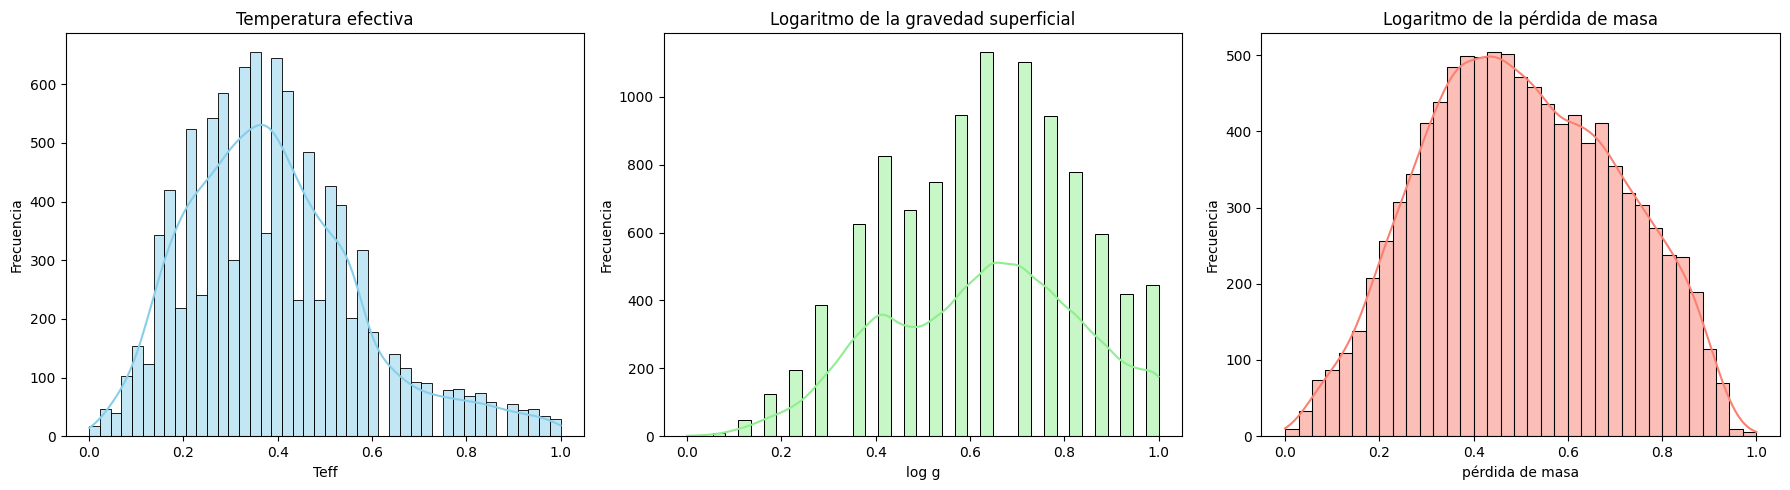

In [128]:
# Crear la figura con 3 subgráficos en una fila
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 fila, 3 columnas

# Primer histograma
sns.histplot(y_scaled[:, 0], kde=True, color="skyblue", ax=axes[0])
axes[0].set_title("Temperatura efectiva")
axes[0].set_xlabel("Teff")
axes[0].set_ylabel("Frecuencia")

# Segundo histograma
sns.histplot(y_scaled[:, 1], kde=True, color="lightgreen", ax=axes[1])
axes[1].set_title("Logaritmo de la gravedad superficial")
axes[1].set_xlabel("log g")
axes[1].set_ylabel("Frecuencia")

# Tercer histograma
sns.histplot(y_scaled[:, 2], kde=True, color="salmon", ax=axes[2])
axes[2].set_title("Logaritmo de la pérdida de masa")
axes[2].set_xlabel("pérdida de masa")
axes[2].set_ylabel("Frecuencia")

# Ajustar el espaciado
plt.tight_layout()
plt.show()

In [129]:
X_train, X_test, y_train, y_test = train_test_split(data, y_scaled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Diseño e implementación de Método ML para predicción de parámetros

In [130]:
time_steps = X_train.shape[1]
input_dimension = 1

sample_size = X_train.shape[0]
X_train_reshaped = X_train.reshape((sample_size, time_steps, input_dimension))
sample_size = X_val.shape[0]
X_val_reshaped = X_val.reshape((sample_size, time_steps, input_dimension))
sample_size = X_test.shape[0]
X_test_reshaped = X_test.reshape((sample_size, time_steps, input_dimension))

In [131]:
print(X_train_reshaped.shape)
print(X_val_reshaped.shape)
print(X_test_reshaped.shape)

(6400, 200, 1)
(1600, 200, 1)
(2000, 200, 1)


In [132]:
# !pip install tensorflow

In [133]:
import tensorflow as tf
import keras

def build_conv1D_model():
    n_timesteps = X_train_reshaped.shape[1] #210
    n_features  = X_train_reshaped.shape[2] #1
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model.add(keras.layers.Conv1D(filters=32, kernel_size=7, activation='relu', name="Conv1D_1"))

    model.add(keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', name="Conv1D_2"))
    tf.keras.layers.BatchNormalization()
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation= "selu", name="Dense_1"))
    model.add(keras.layers.Dense(3, activation = "linear", name="Dense_4"))


    optimizer = tf.keras.optimizers.RMSprop(0.001)

    l = tf.keras.losses.LogCosh()


    model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
    return model

model_conv1D = build_conv1D_model()
model_conv1D.summary()

Model: "model_conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1D_1 (Conv1D)               │ (None, 194, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D_2 (Conv1D)               │ (None, 192, 16)        │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 32)             │        98,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_4 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,243 (391.57 KB)

 Trainable params: 100,243 (391.57 KB)

 Non-trainable params: 0 (0.00 B)

In [134]:
ep = 50
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=5)
history = model_conv1D.fit(X_train_reshaped, y_train, epochs=ep,
                    validation_data = (X_val_reshaped, y_val),
                           verbose=1, callbacks=[callback])

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4506 - mse: 0.4506 - val_loss: 0.0204 - val_mse: 0.0204
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0264 - mse: 0.0264 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

Testing set Mean Abs Error:    2.70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


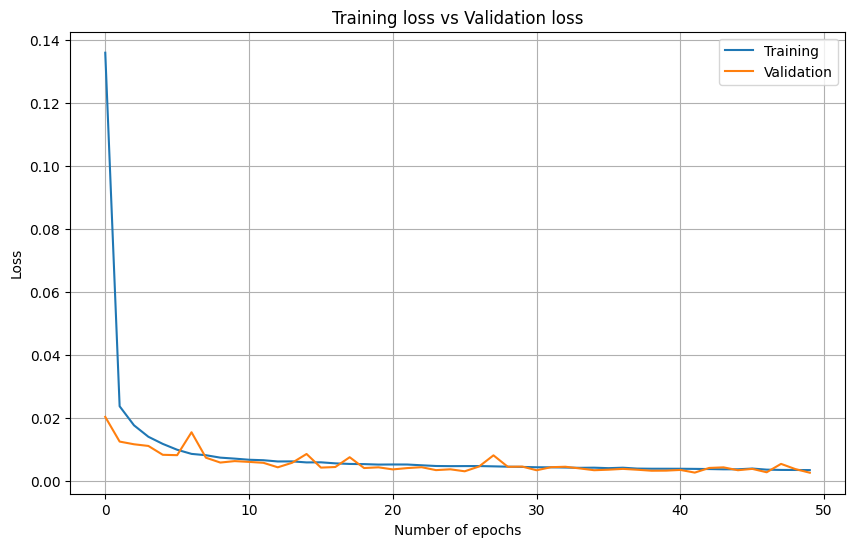

In [135]:
[loss, mae] = model_conv1D.evaluate(X_test_reshaped, y_test, verbose=0)
print("Testing set Mean Abs Error: {:7.2f}".format(mae * 1000))

pred =model_conv1D.predict(X_test_reshaped)

y_pred_inv = scaler.inverse_transform(y_test)


train_loss = history.history['loss']


val_loss = history.history['val_loss']


def plot_train_val(A, B, n, xlabel, ylabel, title):
    plt.figure(1, figsize=(10, 6))
    plt.plot(range(n),A)
    plt.plot(range(n),B)
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend(['Training', 'Validation'])
    plt.show()


plot_train_val(train_loss, val_loss, ep, 'Loss', 'Number of epochs', 'Training loss vs Validation loss')

In [136]:
y_test.shape

(2000, 3)

(2000,)
(2000,)


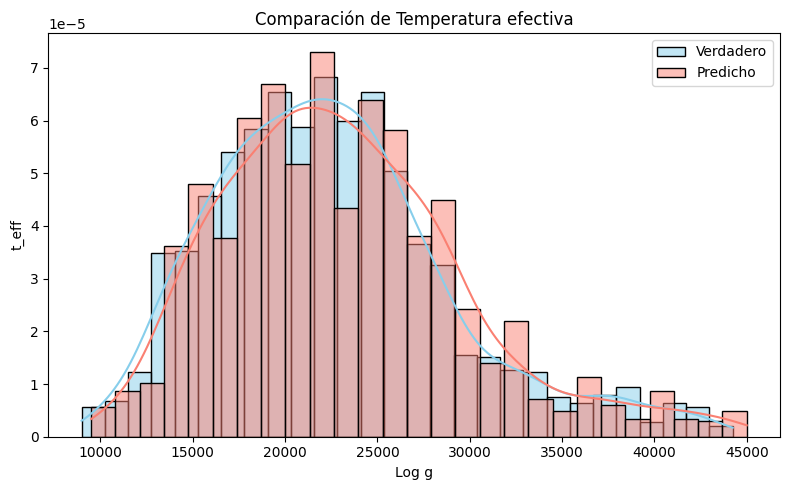

In [137]:
a = scaler.inverse_transform(pred)
print(a[:,0].shape)
b = scaler.inverse_transform(y_test)
print(b[:,0].shape)



plt.figure(figsize=(8, 5))

# Histograma 1
sns.histplot(a[:,0], kde=True, color="skyblue", label="Verdadero", stat="density")

# Histograma 2
sns.histplot(b[:,0], kde=True, color="salmon", label="Predicho", stat="density")

plt.title("Comparación de Temperatura efectiva")
plt.xlabel("Log g")
plt.ylabel("t_eff")
plt.legend()
plt.tight_layout()
plt.show()



In [138]:
y_test[:,2]

array([0.34700766, 0.29900908, 0.63628573, ..., 0.82484339, 0.38349349,
       0.66897348])

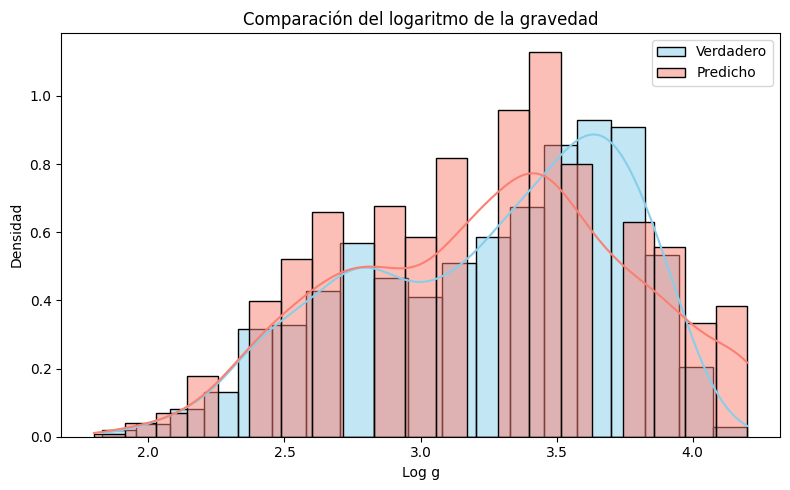

In [139]:
plt.figure(figsize=(8, 5))

# Histograma 1
sns.histplot(a[:,1], kde=True, color="skyblue", label="Verdadero", stat="density")

# Histograma 2
sns.histplot(b[:,1], kde=True, color="salmon", label="Predicho", stat="density")

plt.title("Comparación del logaritmo de la gravedad")
plt.xlabel("Log g")
plt.ylabel("Densidad")
plt.legend()
plt.tight_layout()
plt.show()


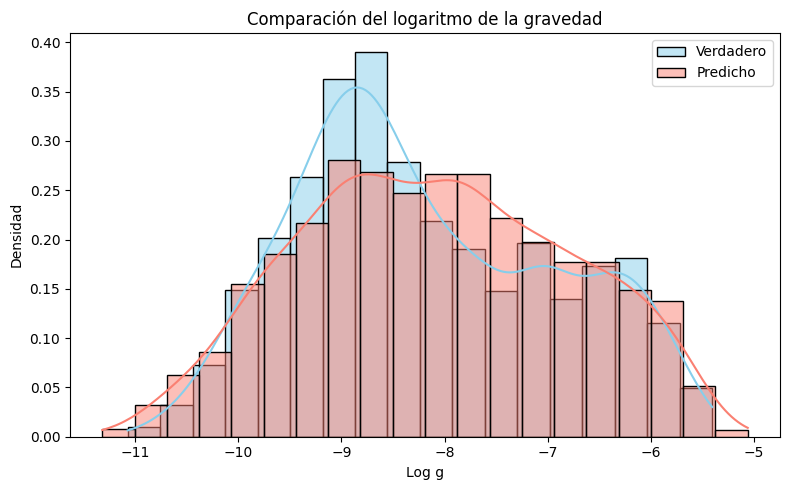

In [140]:
plt.figure(figsize=(8, 5))

# Histograma 1
sns.histplot(a[:,2], kde=True, color="skyblue", label="Verdadero", stat="density")

# Histograma 2
sns.histplot(b[:,2], kde=True, color="salmon", label="Predicho", stat="density")

plt.title("Comparación del logaritmo de la gravedad")
plt.xlabel("Log g")
plt.ylabel("Densidad")
plt.legend()
plt.tight_layout()
plt.show()


## Validación en testing set


## Validación en datos observados

*  Los datos observdados vienen con 8 líneas, y 200 los puntos de flujo cada línea.
* Las líneas en orden son: Si IV 4089,  Hgamma, He I 4387, He I 4471, Si III 4552, Hbeta, Halpha y He I 6678.
* Hay que sacar solo la línea Halpha, para evaluar, ya que nuestros datos de entrenamiento solo contienen H-alpha.

In [61]:
data_observed.shape



(76, 8, 200)

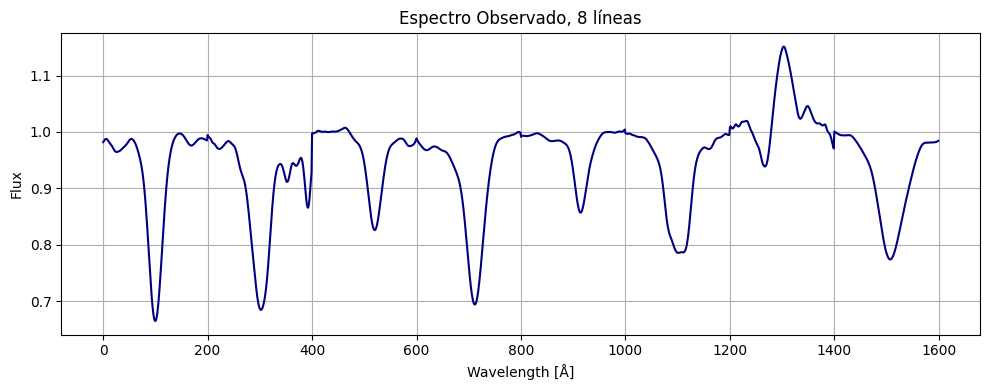

In [143]:
plt.figure(figsize=(10, 4))
plt.plot(range(1600), data_observed[0,:,:].ravel(), color="navy", lw=1.5)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux")
plt.title("Espectro Observado, 8 líneas")
plt.grid(True)
plt.tight_layout()
# Guardar a archivo PNG
#plt.savefig("spectrum_hd60606_4460_4477.png", dpi=300)
plt.show()

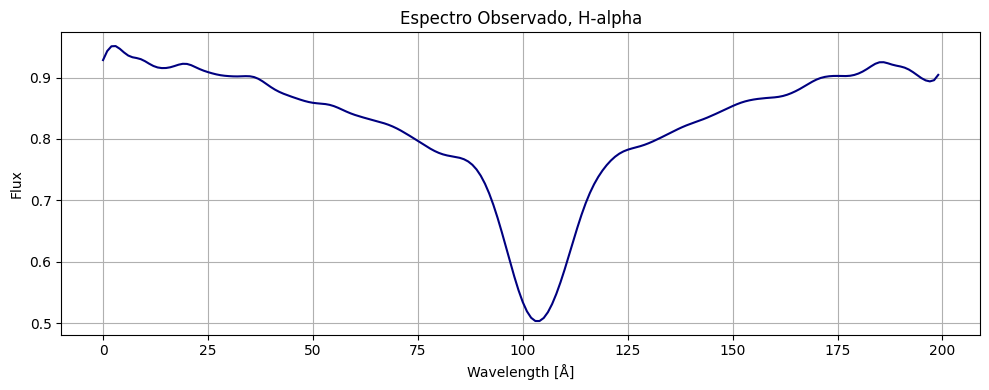

In [144]:
plt.figure(figsize=(10, 4))
plt.plot(range(200), data_observed[12,6,:], color="navy", lw=1.5)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux")
plt.title("Espectro Observado, H-alpha")
plt.grid(True)
plt.tight_layout()
# Guardar a archivo PNG
#plt.savefig("spectrum_hd60606_4460_4477.png", dpi=300)
plt.show()

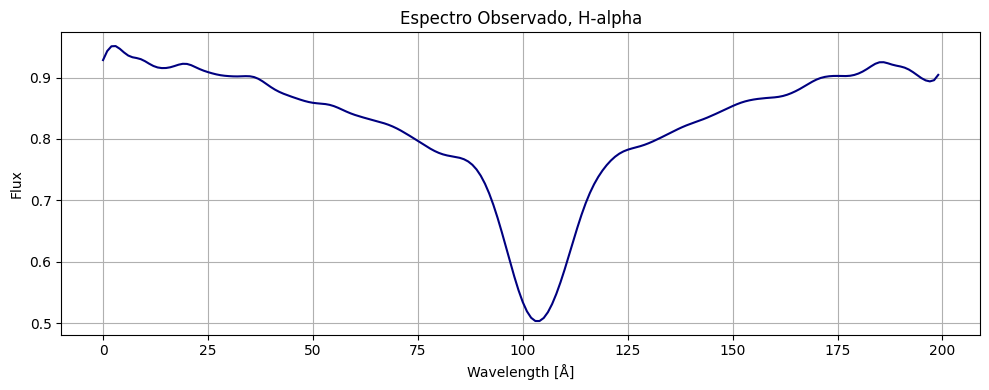

In [145]:
plt.figure(figsize=(10, 4))
plt.plot(range(200), data_observed_p[12,:], color="navy", lw=1.5)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux")
plt.title("Espectro Observado, H-alpha")
plt.grid(True)
plt.tight_layout()
# Guardar a archivo PNG
#plt.savefig("spectrum_hd60606_4460_4477.png", dpi=300)
plt.show()

In [158]:
obs_x_reshaped = data_observed_p[12,:].reshape((1, time_steps, input_dimension))
pred_obs =model_conv1D.predict(obs_x_reshaped)
#print(pred_obs)
print( "--- ", i, "---")
pred_obs_inv = scaler.inverse_transform(pred_obs)
print(pred_obs_inv)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
---  75 ---
[[ 3.4013539e+04  3.7339587e+00 -9.3397102e+00]]


In [166]:
import pandas as pd

predicciones_lista = []
for i in range(data_observed_p.shape[0]):
    obs_x_reshaped = data_observed_p[i,:].reshape((1, time_steps, input_dimension))
    pred_obs =model_conv1D.predict(obs_x_reshaped)
#    print("--",i,"---")
    pred_obs_inv = scaler.inverse_transform(pred_obs)
#    print(pred_obs_inv)

    predicciones_lista.append(pred_obs_inv.flatten())



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

In [167]:
# Crear el DataFrame con las predicciones
df_predicciones = pd.DataFrame(predicciones_lista)
df_predicciones.index.name = "ID_espectro"

# Opcional: agregar nombres de columnas si los conoces
df_predicciones.columns = ["Teff", "Logg", "PerdMasa"]


In [168]:
df_predicciones

,Teff,Logg,PerdMasa
ID_espectro,,,
0,34037.292969,4.371671,-6.718922
1,35787.414062,4.022627,-6.018253
2,35077.457031,4.126910,-5.833731
3,32168.751953,3.598441,-7.188828
4,33524.339844,3.472141,-7.683151
...,...,...,...
71,23961.091797,4.117767,-8.705093
72,26767.607422,3.949071,-10.006947
73,36945.648438,3.106743,-5.904078
